In [1]:
# Master jupyter notebook for Case Study

In [2]:
# importing libraries
import pandas as pd
import sqlite3
from sklearn.preprocessing import LabelEncoder
import datetime
from forex_python.converter import CurrencyRates
from forex_python.converter import RatesNotAvailableError
import plotly.express as px
import nbformat
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# extracting tables from database
def list_tables(database_file):
    connection = sqlite3.connect('data.db')
    cursor = connection.cursor()
    cursor.execute("""select name from sqlite_master where type = 'table';
                    """)
                    
    tables = cursor.fetchall()
    cursor.close()
    connection.close()
    table_names = [table[0] for table in tables]
    return table_names

# saving tables as dataframes
connection = sqlite3.connect('data.db')
query = """select *
        from client as cl;
        """
client = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from client_products as cl;
        """
client_products = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from balances as cl;
        """
balances = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from inv_campaign_eval as cl;
        """
inv_campaign_eval = pd.read_sql_query(query, connection)
connection.close

# merging tables with client data (excluding balances and campaign eval table)
connection = sqlite3.connect('data.db')
query = """
        select cl.client_id, age, job, marital, education, gender, has_deposits, loan, has_insurance, has_mortgage
        from client as cl
        left join client_products as cp on cl.client_id = cp.client_id
        --left join balances as ba on cl.client_id = ba.client_id
        --left join inv_campaign_eval as camp on cl.client_id = camp.client_id;
        """
clients_merged = pd.read_sql_query(query, connection)
connection.close

In [ ]:
# checking for datatypes
print(clients_merged.dtypes)

# checking for missing values
print(client.isnull().sum()) # missing values in Age and Job
print(client_products.isnull().sum()) # no missing values
print(inv_campaign_eval.isnull().sum()) # no missing values
print(balances.isnull().sum()) # no missing values

# dealing with missing values
clients_merged['job'].fillna('unknown', inplace=True) # imputing "unknown" in job
clients_merged['age'].fillna(clients_merged['age'].median(), inplace=True) # imputing median in age

In [5]:
# label encoding categorical variables
le = LabelEncoder()
clients_merged['has_deposits_enc'] = le.fit_transform(clients_merged['has_deposits'])
clients_merged['loan_enc'] = le.fit_transform(clients_merged['loan'])
clients_merged['has_insurance_enc'] = le.fit_transform(clients_merged['has_insurance'])
clients_merged['has_mortgage_enc'] = le.fit_transform(clients_merged['has_mortgage'])
clients_merged['marital_enc'] = le.fit_transform(clients_merged['marital'])
clients_merged['education_enc'] = le.fit_transform(clients_merged['education'])
clients_merged['gender_enc'] = le.fit_transform(clients_merged['gender'])
clients_merged['job_enc'] = le.fit_transform(clients_merged['job'])

In [6]:
# extracting encoding labels for future reference
job_labels = clients_merged[['job', 'job_enc']].drop_duplicates().sort_values('job_enc')
gender_labels = clients_merged[['gender', 'gender_enc']].drop_duplicates().sort_values('gender_enc')
education_labels = clients_merged[['education', 'education_enc']].drop_duplicates().sort_values('education_enc')
marital_labels = clients_merged[['marital', 'marital_enc']].drop_duplicates().sort_values('marital_enc')
has_mortgage_labels = clients_merged[['has_mortgage', 'has_mortgage_enc']].drop_duplicates().sort_values('has_mortgage_enc')
has_insurance_labels = clients_merged[['has_insurance', 'has_insurance_enc']].drop_duplicates().sort_values('has_insurance_enc')
loan_labels = clients_merged[['loan', 'loan_enc']].drop_duplicates().sort_values('loan_enc')
has_deposits_labels = clients_merged[['has_deposits', 'has_deposits_enc']].drop_duplicates().sort_values('has_deposits_enc')

In [7]:
# editing table balances
# removing time from datetime
balances['date'] = pd.to_datetime(balances['date'])
balances['date'] = balances['date'].dt.date

# fetching currency exchange rates for EUR and USD
c = CurrencyRates()

dates = balances['date'].drop_duplicates()
target_currency = 'CZK'

# EUR
base_currency = 'EUR'

eur_rates_date = []
eur_rates_rate = []

for date in dates:
    rate = c.get_rate(base_currency, target_currency, date)
    eur_rates_date.append(date)
    eur_rates_rate.append(rate)

eur_df = pd.DataFrame({'date': eur_rates_date, 'eur_rate': eur_rates_rate})

# USD
base_currency = 'USD'

usd_rates_date = []
usd_rates_rate = []

for date in dates:
    rate = c.get_rate(base_currency, target_currency, date)
    usd_rates_date.append(date)
    usd_rates_rate.append(rate)

usd_df = pd.DataFrame({'date': usd_rates_date, 'usd_rate': usd_rates_rate})

# mapping exchange rate columns into balances dataframe
balances = pd.merge(balances, eur_df, on = 'date')
balances = pd.merge(balances, usd_df, on = 'date')



In [8]:
# creating column with balances recalculated to czk
for index, row in balances.iterrows():
    if row['currency'] == 'EUR':
        balances.at[index, 'fx_rate'] = balances.at[index, 'eur_rate']
    elif row['currency'] == 'USD':
        balances.at[index, 'fx_rate'] = balances.at[index, 'usd_rate']
    else:
        balances.at[index, 'fx_rate'] = 1

balances['balance_in_czk'] = balances['balance']*balances['fx_rate']

In [9]:
# table balances: editing and feature engineering from variables: balance, currency
# encoding outcome variable 
inv_campaign_eval['poutcome_enc'] = le.fit_transform(inv_campaign_eval['poutcome'])

# last balance
last_timestamp_index = balances.groupby('client_id')['date'].idxmax()
last_timestamp_df = balances.loc[last_timestamp_index]
last_timestamp_df.rename(columns={'balance_in_czk': 'last_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, last_timestamp_df[['last_balance','client_id']], on = 'client_id')

# mean balance
mean_bal_by_client = balances.groupby('client_id')['balance_in_czk'].mean().reset_index()
mean_bal_by_client.rename(columns={'balance_in_czk': 'mean_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, mean_bal_by_client[['mean_balance','client_id']], on = 'client_id')

# min balance
min_bal_by_client = balances.groupby('client_id')['balance_in_czk'].min().reset_index()
min_bal_by_client.rename(columns={'balance_in_czk': 'min_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, min_bal_by_client[['min_balance','client_id']], on = 'client_id')

# max balance
max_bal_by_client = balances.groupby('client_id')['balance_in_czk'].max().reset_index()
max_bal_by_client.rename(columns={'balance_in_czk': 'max_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, max_bal_by_client[['max_balance','client_id']], on = 'client_id')

# currency (encoded)
clients_merged = pd.merge(clients_merged, balances[['client_id','currency']].drop_duplicates(), on = 'client_id')
clients_merged['currency_enc'] = le.fit_transform(clients_merged['currency'])
currency_labels = clients_merged[['currency', 'currency_enc']].drop_duplicates().sort_values('currency_enc')

In [ ]:
# creating table first round of campaign - original columns (for visualizations)
first_round_vis = clients_merged[['client_id', 'age', 'job', 'marital', 'education', 'gender','has_deposits', 'loan', 'has_insurance', 'has_mortgage', 'last_balance','mean_balance', 'min_balance', 'max_balance', 'currency']]
first_round_vis = pd.merge(inv_campaign_eval[['client_id','poutcome']], first_round_vis, on = 'client_id')
first_round_vis['age'] = first_round_vis['age'].astype(int)

In [ ]:
# visualizations of data from first round of campaign
# TO DO

plt.figure(figsize=(40, 15))

plt.subplot(1, 4, 1)
sns.countplot(x='job', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 2)
sns.countplot(x='gender', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 3)
sns.countplot(x='education', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 4)
sns.countplot(x='marital', hue='poutcome', data=first_round_vis, palette='viridis')

plt.tight_layout()
plt.show()
# ------------------------------------------------------------------------------------------
plt.figure(figsize=(40, 15))

plt.subplot(1, 4, 1)
sns.countplot(x='has_deposits', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 2)
sns.countplot(x='loan', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 3)
sns.countplot(x='has_insurance', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 4)
sns.countplot(x='has_mortgage', hue='poutcome', data=first_round_vis, palette='viridis')

plt.tight_layout()
plt.show()

In [10]:
# creating table first round of campaign - encoded columns (for modeling)
first_round_clients = clients_merged[['client_id', 'age', 'has_deposits_enc', 'loan_enc', 'has_insurance_enc', 'has_mortgage_enc','marital_enc', 'education_enc', 'gender_enc', 'job_enc', 'last_balance','mean_balance', 'min_balance', 'max_balance', 'currency_enc']]
first_round_clients = pd.merge(inv_campaign_eval[['client_id','poutcome_enc']], first_round_clients, on = 'client_id')
first_round_clients['age'] = first_round_clients['age'].astype(int)

In [34]:
# creating X-matrix of predictors and y-outcome variable
X = first_round_clients.drop(['client_id','poutcome_enc'], axis = 1)
y = first_round_clients['poutcome_enc']

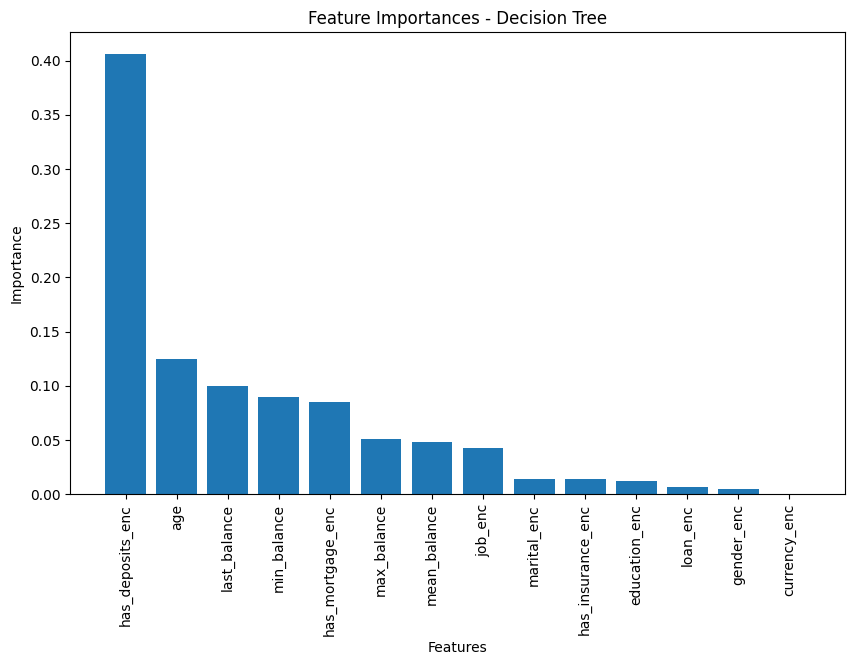

In [54]:
# selecting most important features from X using feature importance
classifier = DecisionTreeClassifier(max_depth=10, min_samples_split=4)

classifier.fit(X, y)
importances = classifier.feature_importances_
feature_names = ['age', 'has_deposits_enc', 'loan_enc', 'has_insurance_enc', 'has_mortgage_enc',
                     'marital_enc', 'education_enc', 'gender_enc', 'job_enc', 'last_balance',
                     'mean_balance', 'min_balance', 'max_balance', 'currency_enc']

sorted_data = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse = True)
sorted_feature_names, sorted_importances = zip(*sorted_data)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances - Decision Tree')
plt.bar(sorted_feature_names, sorted_importances, align="center")
plt.xticks(sorted_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# based on decision tree and feature importances, we consider as most important these variables:
# 'has_deposits_enc', 'age', 'last_balance','min_balance', 'has_mortgage_enc','max_balance','mean_balance','job_enc'
X = X[['has_deposits_enc', 'age', 'last_balance','min_balance', 'has_mortgage_enc','max_balance','mean_balance','job_enc']]

In [58]:
# performing train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)